# Robot dance: a city-wise automatic control of Covid-19 mitigation levels

Robot dance is an automatic control system that considers a complex network of cities with working mobility between them during the period of an epidemic. 
It proposes a control framework that suggests the level of protective measures, in order to avoid the collapse of the health system. 
The model is the following: let a graph with $K$ cities, each one with population $N_i$, and

$$
S_i + E_i + I_i + R_i = 1, i=1,\dots,K.
$$

Let $\alpha(t)$ be a binary coefficient function with $\alpha(t) = 1$ in the time spent at the original node and $\alpha(t) = 0$ during the day. 
Set $T_{\mathrm{inc}}$ and $T_{\mathrm{inf}}$ the incubation and the infection periods. 
During the night, the system works as a SEIR model, written as

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i,
\end{split}
$$

But the cities have commuting, which changes the dynamic of infections.
Let $p_{ij}$ represent the percentage of individuals of node $i$ that work at $j$.
The orginal model consideres that $p_{ij}(t)$ is a function of the time which decreases linearly with $r_j(t)$. 
Here we treat it as a constant.
During the day, the effective population at $i$ is $P_i^{\mathrm{eff}} = \sum_{j=1}^K p_{ji} N_j$.

The number of working people from $i$ that get exposed to infectious individuals from $j$ is 

$$
p_{ij} S_i(t) I_j^{\mathrm{eff}}(t),
$$

where the effective infection ratio is 

$$
I_j^{\mathrm{eff}}(t) = \frac{1}{P_j^{\mathrm{eff}}} \sum_{k=1}^K p_{kj} I_k N_k,
$$

that represents the number of incoming infected individuals from the other cities to $j$ normalized by the effective population there. 

The equations are, therefore, 

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) + (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i.
\end{split}
$$

We can say that $r_i(t) = \beta_i(t)/\gamma = \beta_i(t) T_{\mathrm{inf}}$.
The variable $r_j(t)$ is the control variable that means the reproductive number at time $t$ at city $j$.
They minimize a function changing this function. 

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sp
from scipy.sparse.linalg import eigs, svds

Model code without vaccination.

In [8]:
def model_ode(t, y, alpha, beta, tau, gamma, K, p_matrix, population, population_eff):
    """
    Defines a system of ordinary differential equations (ODEs) for a compartmental model in epidemiology.

    Parameters:
    t (float): The current time.
    y (array-like): The current state of the system. Should be a 1D array of length 4*K, 
                    where the first K elements represent the susceptible individuals, 
                    the next K elements represent the exposed individuals, 
                    the next K elements represent the infectious individuals, 
                    and the last K elements represent the recovered individuals.
    alpha (float): Proportion of the night among the 24 hours.
    beta (array-like): The transmission rate for each city. 
                       Should be a 1D array of length K.
    tau (float): The rate at which exposed individuals become infectious (the inverse of the incubation period).
    gamma (float): The recovery rate (the inverse of the infectious period).
    K (int): The number of cities or groups in the population.
    p_matrix (array-like): A matrix that represents the transitions between different cities. 
                           Should be a 2D array of shape (K, K).
    population (array-like): The total population in each city. 
                             Should be a 1D array of length K.
    population_eff (array-like): The effective population during the day.
                                 Should be a 1D array of length K.
                                 P_i^{\mathrm{eff}} = \sum_{j=1}^K p_matrix{ji} population_j
                                 
    Returns:
    array-like: The rates of change of the susceptible, exposed, infectious, and recovered individuals. 
                Returns a 1D array of length 4*K.
    """
    S, E, I, R = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha * beta * S * I - (1-alpha) * S * (p_matrix @ (beta * I_eff))
    E_dot = -S_dot - tau * E
    I_dot = tau * E - gamma * I
    R_dot = gamma * I
    
    return np.hstack([S_dot, E_dot, I_dot, R_dot])

We consider for the experiments a metropolitan area. 
Therefore, there is a centralized city that receives all the population.

In [3]:
transition_matrix = pd.read_csv('../data/rio_de_janeiro_transition_matrix.csv', index_col=0).to_numpy()
population_size = pd.read_csv('../data/rio_de_janeiro_population.csv').to_numpy()[:,1]

We are considering real data from the metropolitan area of Rio de Janeiro.

In [9]:
# number of cities
K = population_size.shape[0]

# Population sizes
population = population_size.astype(np.float64)

p_matrix = transition_matrix.astype(np.float64)
population_eff = population @ p_matrix 

# working hours between 6 and 18 hours.
alpha = 1/2
beta = np.array([0.9, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])
tau = 1/5.2
gamma = 1/2.9

args = (alpha, beta, tau, gamma, K, p_matrix, population, population_eff)

Now, we fix the initial conditions. 
We consider the beggining of the disease, so only the capital has the disease with an exposed individual.

In [10]:
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 1/population[0]
y0[0] = 1-y0[K]

In [11]:
n_days = 300
t_eval = np.linspace(0, n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
               )

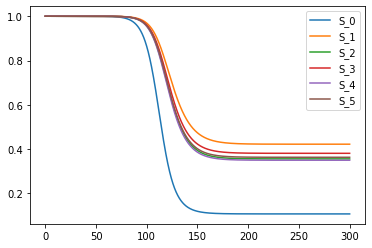

In [14]:
plt.plot(sol.t, sol.y[0], label='S_0')
plt.plot(sol.t, sol.y[1], label='S_1')
plt.plot(sol.t, sol.y[2], label='S_2')
plt.plot(sol.t, sol.y[3], label='S_3')
plt.plot(sol.t, sol.y[4], label='S_4')
plt.plot(sol.t, sol.y[5], label='S_5')

plt.legend()
plt.show()

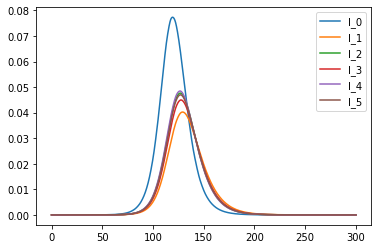

In [15]:
plt.plot(sol.t, sol.y[2*K+0], label='I_0')
plt.plot(sol.t, sol.y[2*K+1], label='I_1')
plt.plot(sol.t, sol.y[2*K+2], label='I_2')
plt.plot(sol.t, sol.y[2*K+3], label='I_3')
plt.plot(sol.t, sol.y[2*K+4], label='I_4')
plt.plot(sol.t, sol.y[2*K+5], label='I_5')

plt.legend()
plt.show()

Now, with different rates of commuting.

In [8]:
K = 5
population = np.array([1e6, 1e4, 1e4, 1e4, 1e4])

p_0j = 0.2
p_j0 = 0.01


p_matrix = np.array([
    [1-4*p_0j, p_0j, p_0j, p_0j, p_0j],
    [p_j0, 1-p_j0, 0, 0, 0],
    [p_j0, 0, 1-p_j0, 0, 0],
    [p_j0, 0, 0, 1-p_j0, 0],
    [p_j0, 0, 0, 0, 1-p_j0]
])
population_eff = population @ p_matrix 

# working hours between 6 and 18 hours.
alpha = lambda t: 1.0 if t % 24 < 6 or t % 24 > 18 else 0.0
beta = np.array([0.5, 0.4, 0.4, 0.4, 0.4]) / 24
tau = 1/(5.2 * 24)
gamma = 1/(2.9 * 24)

args = (alpha, beta, tau, gamma, population, p_matrix, population_eff, K)

In [9]:
n_days = 300
t_eval = np.linspace(0, 24 * n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,24 * n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval, 
               )

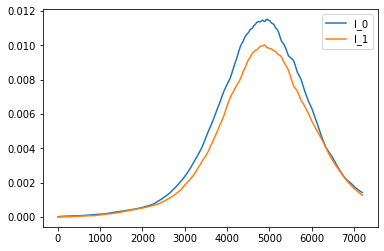

In [10]:
plt.plot(sol.t, sol.y[2*K], label='I_0')
plt.plot(sol.t, sol.y[2*K+2], label='I_1')
plt.legend()
plt.show()

## Calculating $\mathcal{R}_0$

In [51]:
def r0_calc(_beta, _populations, _P1, _alpha, _gamma):
    
    B = np.diag(_beta)
    N = np.diag(_populations)

    p_matrix = np.diag(1-_P1)
    p_matrix[:,0] += _P1

    population_eff = _populations @ p_matrix 
    E_inv = np.diag(1/population_eff)

    A = _alpha * B + (1-_alpha) * p_matrix @ B @ E_inv @ p_matrix.T @ N
    rho_A = abs(eigs(A, k=1, which='LM', return_eigenvectors=False)[0])
    return rho_A/gamma

In [21]:
K = 5

populations = np.array([7.0, 1.0, 1.0, 1.0, 1.0])
beta = np.array([0.7, 0.5, 0.5, 0.5, 0.5])

tau = 1/(5.2)
gamma = 1/(2.9)
alpha = 1/3


r0_list = np.zeros(100000)
P1_list = np.zeros_like(r0_list)
for i in range(100000):
    P1 = np.random.random(size=5)
    P1[0] = 1.0
    P1_list[i] = max(P1[1:])
    r0_list[i] = r0_calc(beta, populations, P1, alpha, gamma)

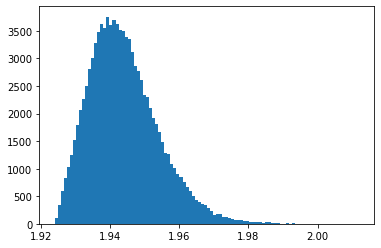

In [22]:
plt.hist(r0_list, bins=100)
plt.show()

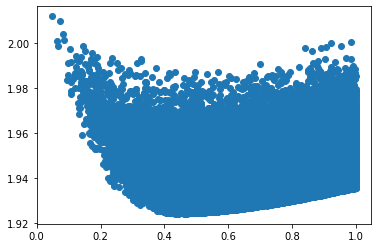

In [23]:
plt.scatter(P1_list, r0_list)

In [62]:
K = 3

populations = np.array([1.0, 0.1, 0.2])
beta = np.array([0.7, 0.5, 0.4])
P1 = np.array([1.0, 0.3, 0.3])

tau = 1/(5.2)
gamma = 1/(2.9)
alpha = 1/3

P1_list = np.linspace(0.0, 1.0, 10000, endpoint=False)

r0_list = np.zeros_like(P1_list)
for i, p21 in enumerate(P1_list):
    P1[2] = p21
    r0_list[i] = r0_calc(beta, populations, P1, alpha, gamma)

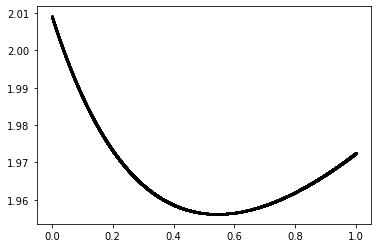

In [77]:
plt.scatter(P1_list, r0_list, s=2, color='black')
#plt.axhline(beta[0]/gamma, color='red')
#plt.plot([alpha_list[0], alpha_list[-1]], [r0_list[0], r0_list[-1]], color='red', linestyle='--')
plt.show()

## This is not quadratic or cubic! It may be another function.

In [300]:
gamma = 0.5
r0_list = np.zeros(100000)
r01_list = np.zeros(100000)
r0_differ = np.zeros_like(r0_list)

for i in range(100000):
    
    alpha = np.random.uniform(0, 1)
    populations = np.random.uniform(1, 100, size=5)
    populations = 100 * np.sort(populations)[::-1]
    
    beta = np.random.uniform(0.0, 0.8, size=5)
    beta[0] = np.random.uniform(max(beta), 0.8)
    
    P1 = np.random.uniform(0, 1, size=5)
    P1[0] = 1.0
    
    a = r0_calc(beta, populations, P1, alpha, gamma)
    r0_list[i] = a
    r01_list[i] = beta[0]/gamma
    
    populations = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
    beta = np.array([0.7, 0.5, 0.5, 0.5, 0.5])
    b = r0_calc(beta, populations, P1, alpha, gamma)
    r0_differ[i] = b

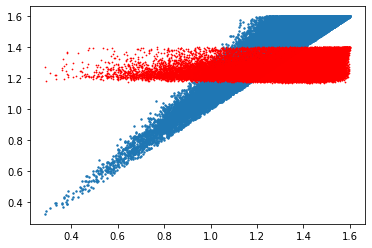

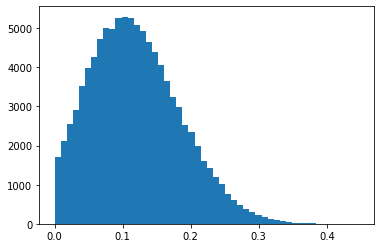

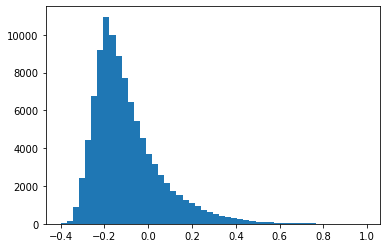

In [301]:
plt.scatter(r0_list, r01_list, s=2)
plt.scatter(r0_list, r0_differ, s=0.5, color='red')
plt.show()

plt.hist(r01_list - r0_list, bins=50)
plt.show()

plt.hist(r0_differ - r0_list, bins=50)
plt.show()